<a href="https://colab.research.google.com/github/yhnx/EN3150_Assignment_03/blob/main/Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#importing required libraries for the job

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

import matplotlib.pyplot as plt
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
 # Check if any GPU is available
 device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
 # If a CUDA device is available, use the first available GPU
 if torch.cuda.is_available():
  device = torch.device("cuda:0")  # Using the first available GPU at index 0
 else:
  device = torch.device("cpu")
 print(f"Using device: {device}")

Using device: cuda:0


In [12]:
#Loading the dataset from drive
dataset_path = '/content/drive/MyDrive/RealWaste'



In [13]:
global IMAGE_SIZE, BATCH_SIZE, CHANNELS, NUM_CLASSES, EPOCH
IMAGE_SIZE = 256
BATCH_SIZE = 16
CHANNELS = 3
EPOCH = 80

In [14]:

transform = transforms.Compose([
    transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),  # Making sure that the size is fixed for all
    transforms.ToTensor(), # Convert to tensor
])

#Load dataset from directory
dataset = ImageFolder(root=dataset_path, transform=transform)


In [15]:
CLASSES = dataset.classes
NUM_CLASSES = len(CLASSES)
print(NUM_CLASSES)

# View class names (subfolder names)
print("Class Names:")
for class_name in dataset.classes:
    print(class_name)

# View class-to-index mapping
print("\nClass-to-Index Mapping:")
for class_name, index in dataset.class_to_idx.items():
    print(f"{index}: {class_name}")

# View total number of samples
print("\nNumber of images:", len(dataset))

# View a single sample (image and label)
img1, label1 = dataset[0]  # Access the first sample
print("Image shape:", img1.shape)  # Shape of the image tensor
print("Label:", label1)  # Integer label corresponding to the class

9
Class Names:
Cardboard
Food Organics
Glass
Metal
Miscellaneous Trash
Paper
Plastic
Textile Trash
Vegetation

Class-to-Index Mapping:
0: Cardboard
1: Food Organics
2: Glass
3: Metal
4: Miscellaneous Trash
5: Paper
6: Plastic
7: Textile Trash
8: Vegetation

Number of images: 4752
Image shape: torch.Size([3, 256, 256])
Label: 0


In [16]:
#splitting the dataset into 70% , 15% and 15% for train, test and valid

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create DataLoaders for validation and test sets

#Set a seed for reproducibility
torch.manual_seed(42)
train_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )
# Set a seed for reproducibility
torch.manual_seed(42)
valid_loader = DataLoader(valid_dataset, batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )


# Set a seed for reproducibility
torch.manual_seed(42)
test_loader = DataLoader(test_dataset,  batch_size= BATCH_SIZE, shuffle=True,
                           num_workers=4,               # Number of workers for data loading
                           pin_memory=True,             # Use pinned memory for GPU transfer
                           prefetch_factor=2,            # Number of batches to prefetch per workers
                           persistent_workers=True      # Keep workers alive between epochs
                         )

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [18]:
# Check the size of SETS
print(f"Training set size: {len(train_loader)}")
print(f"Validation set size: {len(valid_loader)}")
print(f"Test set size: {len(test_loader)}")

Training set size: 208
Validation set size: 45
Test set size: 45


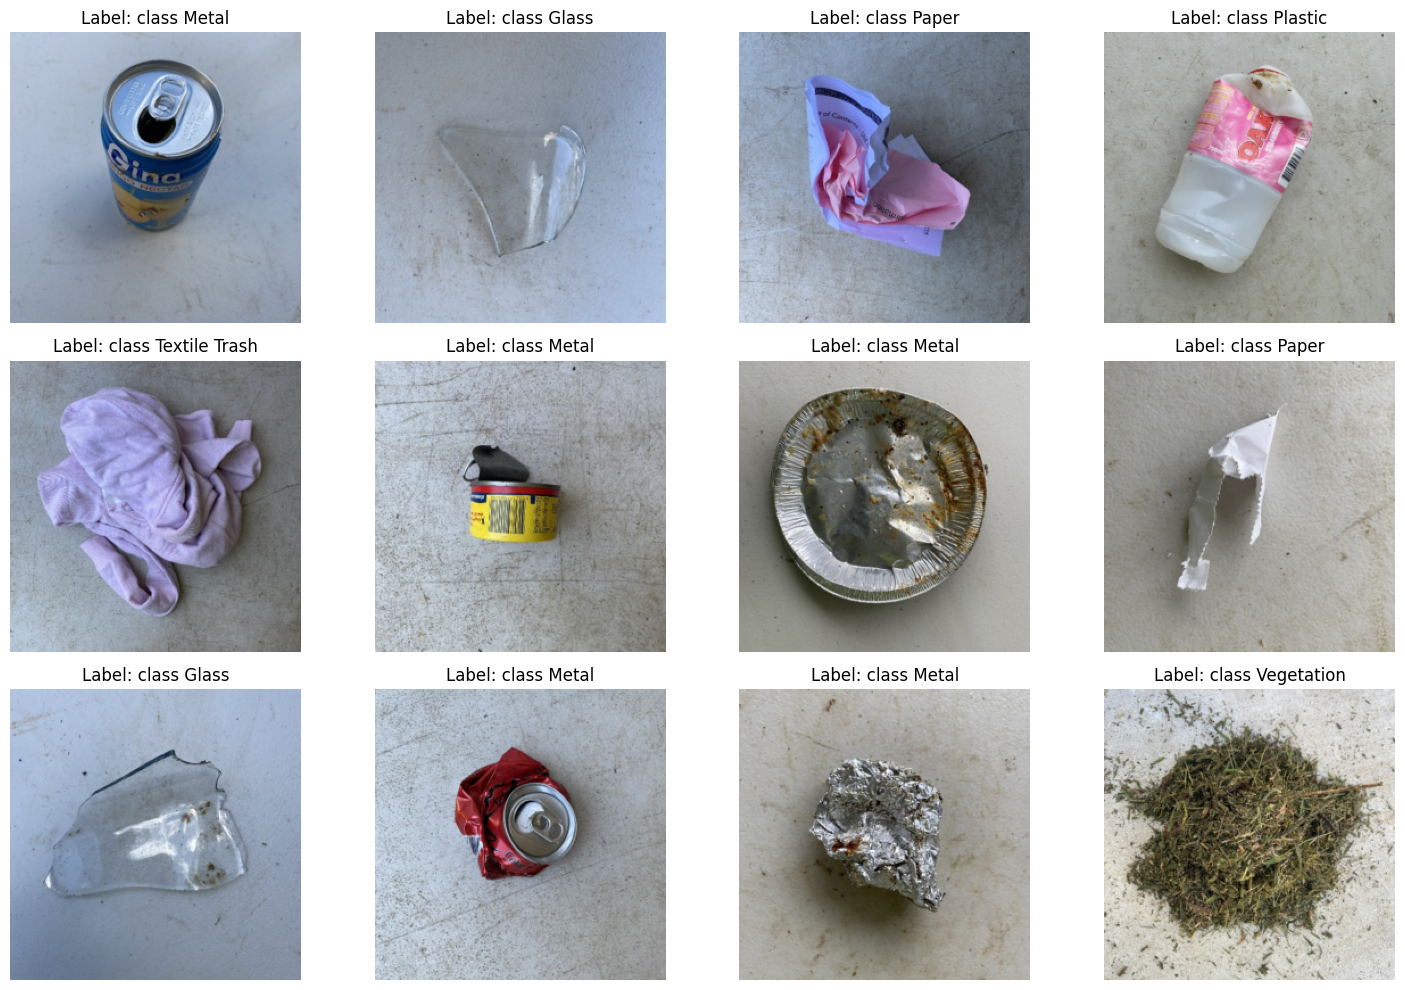

In [26]:
#for a singular image
for images, labels in train_loader:
  fig, axes = plt.subplots(3, 4, figsize=(15, 10))

  # Plot the first 12 images
  for i in range(12):
      row, col = divmod(i, 4)
      ax = axes[row, col]
      ax.imshow(images[i].permute(1, 2, 0))  # Change from C x H x W to H x W x C)
      ax.set_title(f"Label: class {CLASSES[labels[i].item()]}") #display class name
      ax.axis('off')  # Turn off axes

  plt.tight_layout()
  plt.show()
  break


In [29]:
# =====================================================
# 3. Defining the CNN initially on an arbitrary basis!!!
# =====================================================
class WasteCNN(nn.Module):
    def __init__(self, num_classes):
        super(WasteCNN, self).__init__()

        # Conv1: 3x3 kernel
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(2, 2)

        # Conv2: 3x3 kernel with stride
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)

        # Conv3: 5x5 kernel
        self.conv3 = nn.Conv2d(32, 64, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(2, 2)

        # Fully connected layers
        # Input: 64 * 32 * 32 (after last pooling for 256x256 input)
        self.fc1 = nn.Linear(64 * 32 * 32, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)

        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(x)

        x = x.view(x.size(0), -1)  # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

In [30]:
model_1 = WasteCNN(num_classes=NUM_CLASSES)

from torchsummary import summary

model_1.to(device)
summary(model_1, input_size=(3, 256, 256))  # (Channels, Height, Width)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
         MaxPool2d-2         [-1, 16, 128, 128]               0
            Conv2d-3           [-1, 32, 64, 64]           4,640
            Conv2d-4           [-1, 64, 64, 64]          51,264
         MaxPool2d-5           [-1, 64, 32, 32]               0
            Linear-6                  [-1, 256]      16,777,472
            Linear-7                    [-1, 9]           2,313
Total params: 16,836,137
Trainable params: 16,836,137
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.75
Forward/backward pass size (MB): 13.50
Params size (MB): 64.22
Estimated Total Size (MB): 78.48
----------------------------------------------------------------
